In [6]:
import s3fs
import xarray as xr
import xesmf
import matplotlib.pyplot as plt 
import numpy as np

In [10]:
## create specific humidity function
def cal_specific_humid(Tdew,P):
    """
    calculate the specific humidity in kg/kg from ERA5 inputs. 
    assumes that Tdew is in Kelving and P is in pascals (the raw data)
    
    """
    assert Tdew.shape == P.shape, "Temperature and Pressure should be the same shape"
    
    e = 6.112*np.exp((17.67*(Tdew-273.15))/((Tdew-273.15)+243.5))
    q = ((0.622*e)/((P/100) - 0.378*e)) #kg per kg
    return(q)
    

In [39]:
## create a list of inputs to loop over 
## these are a names that correspond to the era5 data sets
data_varaibles = [f'air_temperature_at_2_metres',f'surface_air_pressure',f'dew_point_temperature_at_2_metres']
name_variables = [f'T2D',f'PSFC',f'Q2D','U2D','V2D','SWDOWN','LWDOWN','RAINRATE']

In [7]:
## load in data set of geogrid and then create a subset of curvilinear grid 
## to output the dset data to load
geogrid = xr.open_dataset('./geogrid-files/geo_em.d01.milwaukee.nc')
print(geogrid.attrs)
ds_out = xr.Dataset(
    {
        "lat": (["y","x"],geogrid.XLAT_M[0].values),
        "lon": (["y","x"], geogrid.XLONG_M[0].values),
    }
)



{'TITLE': 'OUTPUT FROM GEOGRID V4.2', 'SIMULATION_START_DATE': '0000-00-00_00:00:00', 'WEST-EAST_GRID_DIMENSION': 100, 'SOUTH-NORTH_GRID_DIMENSION': 115, 'BOTTOM-TOP_GRID_DIMENSION': 0, 'WEST-EAST_PATCH_START_UNSTAG': 1, 'WEST-EAST_PATCH_END_UNSTAG': 99, 'WEST-EAST_PATCH_START_STAG': 1, 'WEST-EAST_PATCH_END_STAG': 100, 'SOUTH-NORTH_PATCH_START_UNSTAG': 1, 'SOUTH-NORTH_PATCH_END_UNSTAG': 114, 'SOUTH-NORTH_PATCH_START_STAG': 1, 'SOUTH-NORTH_PATCH_END_STAG': 115, 'GRIDTYPE': 'C', 'DX': 1000.0, 'DY': 1000.0, 'DYN_OPT': 2, 'CEN_LAT': 43.319992, 'CEN_LON': -88.149994, 'TRUELAT1': 41.5, 'TRUELAT2': 44.5, 'MOAD_CEN_LAT': 43.319992, 'STAND_LON': -88.15, 'POLE_LAT': 90.0, 'POLE_LON': 0.0, 'corner_lats': array([42.810055, 43.82674 , 43.82674 , 42.810055, 42.81002 , 43.826706,
       43.826706, 42.81002 , 42.80555 , 43.83123 , 43.83123 , 42.80555 ,
       42.80552 , 43.831203, 43.831203, 42.80552 ], dtype=float32), 'corner_lons': array([-88.75098 , -88.76108 , -87.53894 , -87.54901 , -88.75711 ,
 

In [8]:
fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
fmap = s3fs.S3Map(f's3://era5-pds/zarr/2010/07/data/{data_varaibles[2]}.zarr', s3=fs)
dset_td = xr.open_zarr(fmap, consolidated=True)
fmap = s3fs.S3Map(f's3://era5-pds/zarr/2010/07/data/{data_varaibles[1]}.zarr', s3=fs)
dset_pa = xr.open_zarr(fmap, consolidated=True)

In [9]:
## determine the nearest coordinates of the geogrid file, and then add 2 to it to be safe
lonsv, latsv = np.meshgrid(-360+dset_td.lon.values,dset_td.lat.values)
## get the id of the lons from geogrid
LON_start = np.abs(lonsv - ds_out.lon[0,0].values)
LON_end = np.abs(lonsv - ds_out.lon[-1,-1].values)

idx_lonstart = np.where(LON_start == LON_start.min())
idx_lonend = np.where(LON_end == LON_end.min())
input_lonstart = idx_lonstart[1][0]-1
input_lonend = idx_lonend[1][0]+1


## get the id of the lats from geogrid
LAT_start = np.abs(latsv - ds_out.lat[0,0].values)
LAT_end = np.abs(latsv - ds_out.lat[-1,-1].values)

idx_latstart = np.where(LAT_start == LAT_start.min())
idx_latend = np.where(LAT_end == LAT_end.min())
input_latstart = idx_latstart[0][0]+1
input_latend = idx_latend[0][0]-1

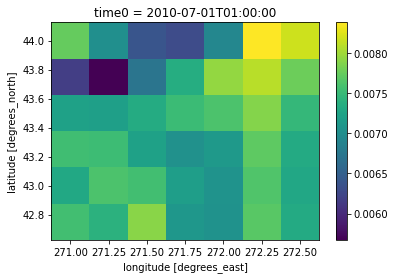

In [11]:
## take out the data of interest
dset_subset_td = dset_td[data_varaibles[2]][:,input_latend:input_latstart,input_lonstart:input_lonend]
dset_subset_pa = dset_pa[data_varaibles[1]][:,input_latend:input_latstart,input_lonstart:input_lonend]
dset_kg = cal_specific_humid(dset_subset_td, dset_subset_pa)
dset_kg[1].plot()

In [12]:
## create the subset dset
lonsv, latsv = np.meshgrid(-360+dset_subset_td.lon.values,dset_subset_td.lat.values)

data_array_input = xr.Dataset(
    {
    name_variables[0]:(["y","x"],dset_subset_td[1,:,:].values),
    }
    ,coords={
        "lat": (["y","x"],latsv),
        "lon": (["y","x"], lonsv),
    }
)   
data_array_input

<xarray.Dataset>
Dimensions:  (y: 6, x: 7)
Coordinates:
    lat      (y, x) float32 44.0 44.0 44.0 44.0 44.0 ... 42.75 42.75 42.75 42.75
    lon      (y, x) float32 -89.0 -88.75 -88.5 -88.25 ... -88.0 -87.75 -87.5
Dimensions without coordinates: y, x
Data variables:
    T2D      (y, x) float32 283.2 281.8 280.4 280.1 ... 281.9 281.9 283.2 282.5

In [13]:
regridder = xesmf.Regridder(data_array_input, ds_out, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_6x7_114x99.nc 
Reuse pre-computed weights? False 
Input grid shape:           (6, 7) 
Output grid shape:          (114, 99) 
Periodic in longitude?      False

In [14]:
dout = regridder(data_array_input)

In [21]:
dout.dims['y']

114

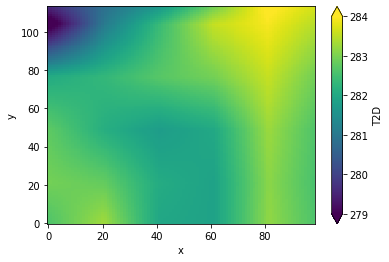

In [106]:
dout.T2D.plot(vmin=279,vmax=284)

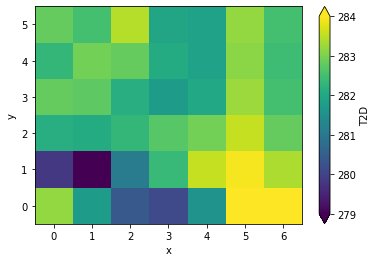

In [107]:
data_array_input.T2D.plot(vmin=279,vmax=284)

<xarray.DataArray 'surface_air_pressure' (y: 8, x: 9)>
array([[     nan,      nan,      nan,      nan,      nan, 297.8125,
        297.6875, 296.5   , 296.5   ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        297.875 , 296.875 , 296.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        295.75  , 296.625 , 296.625 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        293.375 , 294.75  , 295.9375],
       [     nan,      nan,      nan,      nan,      nan,      nan,
        293.1875, 293.625 , 294.8125],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 293.875 , 293.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 292.5625, 292.875 ],
       [     nan,      nan,      nan,      nan,      nan,      nan,
             nan, 291.75  , 292.25  ]], dtype=float32)
Coordinates:
    lat      (y, x) float32 42.5 42.5 42.5 42.5 42.5 ... 44.25 44.25 44.25 44.25
    lon      (y, x) float32 -89.25 -89.0 -88.75 -88.5 ... -87.75 -87.5 -87.25
Dimensions without coordinates: y, x

In [44]:
dout.surface_air_pressure[0,0]

<xarray.DataArray 'surface_air_pressure' ()>
array(nan, dtype=float32)
Coordinates:
    lon      float32 -88.75
    lat      float32 42.81

In [62]:
## longwave radiation
#s3://jupiter-reference-data/era5/rlds/surface_thermal_radiation_downwards_1980_01-03.nc

import os
import xarray as xr

variable_name_longwave = 'surface_thermal_radiation_downwards'
data_variable_longwave = 'strd'
file_name = f'{variable_name}_1980_01-03.nc'

os.system(f'aws s3 cp s3://jupiter-reference-data/era5/rlds/{file_name} .')
darr = xr.open_dataset(file_name)[data_variable]
darr

download: s3://jupiter-reference-data/era5/rlds/surface_thermal_radiation_downwards_1980_01-03.nc to ./surface_thermal_radiation_downwards_1980_01-03.nc


<xarray.DataArray 'strd' (time: 2184, latitude: 721, longitude: 1440)>
[2267516160 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 ... 1980-03-31T23:00:00
Attributes:
    units:      J m**-2
    long_name:  Surface thermal radiation downwards

In [12]:
import s3fs
import xarray as xr
import xesmf
import numpy as np
import pandas as pd
import os

"""
This code assumes that you are going to start at the BEGINNING OF A MONTH to generate the inputs. 
"""

## options to set
start_date_want = '2010-06-01' #set
end_date_want = '2010-11-01' #set
freq_want = '1H' #era5 is 1H
save_location = './'

## create a list of inputs to loop over (data is ERA5, NAME is the names HRLDAS is looking for)
data_varaibles = [f'air_temperature_at_2_metres',f'surface_air_pressure',f'dew_point_temperature_at_2_metres',
                 f'eastward_wind_at_10_metres',f'northward_wind_at_10_metres',
                 f'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation',
                 f'precipitation_amount_1hour_Accumulation',f'strd']
name_variables = [f'T2D',f'PSFC',f'Q2D',f'U2D',f'V2D',f'SWDOWN',f'RAINRATE','LWDOWN']

## Geogrid data that we want to load in
## this happens once
geogrid = xr.open_dataset('./geogrid-files/geo_em.d01.milwaukee.nc')



## these are from LUKE MADDAUS
variable_name_longwave = 'surface_thermal_radiation_downwards'
# file_name_LW = f'{variable_name}_1980_01-03.nc'

#os.system(f'aws s3 cp s3://jupiter-reference-data/era5/rlds/{file_name} .')
#darr = xr.open_dataset(file_name)[data_variable]
#darr




## This is a big cell that is going to basically be the .py file that we make above!

def cal_specific_humid(Tdew,P,tdew_name,p_name):
    """
    calculate the specific humidity in kg/kg from ERA5 inputs. 
    assumes that Tdew is in Kelving and P is in pascals (the raw data)
    
    """
    
    
    e = 6.112*np.exp((17.67*(Tdew[tdew_name]-273.15))/((Tdew[tdew_name]-273.15)+243.5))
    q = ((0.622*e)/((P[p_name]/100) - 0.378*e)) #kg per kg
    
    return(q.to_dataset(name=tdew_name))

def get_region_era5(era5,geo):
    
    """
    Takes an era5 file, and a geogrid file, and then calculates the start and end points 
    of the era5 file based on the geogrid file. Adds 3 to each edge of the ERA5 data for 
    a safety protocol
    """
    
    ## determine the nearest coordinates of the geogrid file, and then add 3
    lonsv, latsv = np.meshgrid(-360+era5.lon.values,era5.lat.values)
    ## get the id of the lons from geogrid
    LON_start = np.abs(lonsv - geo.lon[0,0].values)
    LON_end = np.abs(lonsv - geo.lon[-1,-1].values)

    idx_lonstart = np.where(LON_start == LON_start.min())
    idx_lonend = np.where(LON_end == LON_end.min())
    input_lonstart = idx_lonstart[1][0]-3
    input_lonend = idx_lonend[1][0]+3


    ## get the id of the lats from geogrid
    LAT_start = np.abs(latsv -geo.lat[0,0].values)
    LAT_end = np.abs(latsv - geo.lat[-1,-1].values)

    idx_latstart = np.where(LAT_start == LAT_start.min())
    idx_latend = np.where(LAT_end == LAT_end.min())
    input_latstart = idx_latstart[0][0]+3
    input_latend = idx_latend[0][0]-3
    
    return(input_lonstart,input_lonend,input_latend,input_latstart) # order due to the way era5 defines coordinates

def transform_era5_to_dataarray_2d(dsubset):
    
    """
    takes a zarr dataarray, and creates a dataset that has the correct lats and lons to 
    feed into HRLDAS
    """
    
    lonsv, latsv = np.meshgrid(-360+dsubset.lon.values,dsubset.lat.values) 
    # meshgrid is based on the notation of ERA5 data!

    data_array_input = xr.Dataset(
        {
        name_variables[0]:(["y","x"],dsubset[0,1:-1,1:-1].values),
        }
        ,coords={
            "lat": (["y","x"],latsv[1:-1,1:-1]),
            "lon": (["y","x"], lonsv[1:-1,1:-1]),
            "lat_b": (["y_b","x_b"], 0.25*(latsv[:-1,:-1]+latsv[1:,1:]+latsv[1:,:-1]+latsv[:-1,1:])),
            "lon_b": (["y_b","x_b"], 0.25*(lonsv[:-1,:-1]+lonsv[1:,1:]+lonsv[1:,:-1]+lonsv[:-1,1:])),
            
            
        }
    )   
    return(data_array_input)

def transform_era5_to_dataarray_3d(dsubset3d,name):
    
    """
    takes a zarr dataarray, and creates a dataset that has the correct lats and lons to 
    feed into HRLDAS
    """
    
    lonsv, latsv = np.meshgrid(-360+dsubset3d.lon.values,dsubset3d.lat.values) 
    # meshgrid is based on the notation of ERA5 data!

    data_array_input = xr.Dataset(
        {
        name:(["time","y","x"],dsubset3d[:,1:-1,1:-1].values),
        }
        ,coords={
            "lat": (["y","x"],latsv[1:-1,1:-1]),
            "lon": (["y","x"], lonsv[1:-1,1:-1]),
            "lat_b": (["y_b","x_b"], 0.25*(latsv[:-1,:-1]+latsv[1:,1:]+latsv[1:,:-1]+latsv[:-1,1:])),
            "lon_b": (["y_b","x_b"], 0.25*(lonsv[:-1,:-1]+lonsv[1:,1:]+lonsv[1:,:-1]+lonsv[:-1,1:])),
            
            
        }
    )   
    return(data_array_input)


def get_regridder(grid_input,grid_out,option="bilinear"):
    """
    this function takes the two grids, and gets a regridder that we can use to get all gridded data!
    depends on xemsf.
    Option should be the method you want, default is "bilinear"
    """
    regridder_weights=xesmf.Regridder(grid_input, grid_out, option)
    return(regridder_weights)
    
######################################################################
# begin actual code
ds_out = xr.Dataset(
    {
        "lat": (["y","x"],geogrid.XLAT_M[0].values),
        "lon": (["y","x"], geogrid.XLONG_M[0].values),
        "lat_b": (["y_b","x_b"],geogrid.XLAT_C[0].values),
        "lon_b": (["y_b","x_b"],geogrid.XLONG_C[0].values)
    }
)

## load in a SINGLE time zarr file that is independent of the time loop below. This will allow us to calculate the 
## boundaries of the 
fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
fmap = s3fs.S3Map(f's3://era5-pds/zarr/2010/07/data/{data_varaibles[0]}.zarr', s3=fs)
dset_t = xr.open_zarr(fmap, consolidated=True)

subset_lon_start,subset_lon_end,subset_lat_start,subset_lat_end = get_region_era5(dset_t,ds_out)



# Example on how to use the output
# of era5 region dset_subset_td = dset_td[data_varaibles[2]][:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]
_temp =  dset_t[data_varaibles[0]][:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]
data_array_era5 = transform_era5_to_dataarray_2d(_temp)

## now we get the regridder weights (only need this once)
regridder_era5_to_geogrid = get_regridder(data_array_era5,ds_out)
regridder_era5_to_geogrid_conserve = get_regridder(data_array_era5,ds_out,"conservative")

## works up to here!
dates_to_loop = pd.date_range(start=start_date_want,end=end_date_want, freq=freq_want)
date_year = str(dates_to_loop[0].year)
date_month = str(dates_to_loop[0].month).zfill(2)

variables_to_save = [None]*8   
        
for ii, date in enumerate(dates_to_loop): # we loop over each of these values
    
    # naming convention is of the format
    # YYYYMMDDHH.LDASIN_DOMAIN1
    
    file_name = str(date.year).zfill(4) + str(date.month).zfill(2) + str(date.day).zfill(2) + str(date.hour).zfill(2) + '.LDASIN_DOMAIN1'
    
    ## increment the longwave data
    
    
    date_month_new = str(date.month).zfill(2)
    
    ## determine if we need to load in a new data set
    if ii == 0:
        load_new = True
    elif date_month_new == date_month:
        load_new = False
    else:
        date_month = date_month_new
        load_new = True
        print(date_month)
    
    if (date.month % 3  == 1) or (ii == 0):
        load_LWDOWN = True
    else:
        load_LWDOWN = False

    
    ## if we should load the data  LOAD IT
    if load_new:
        for i,_name in enumerate(name_variables):
            
            # do we need to load in longwave data? It is collected every three months
            if (i == 7) and (load_LWDOWN): #LWDOWN branch
                
                # which ending do we need?
                if (date.month>= 1) and (date.month<=3):
                    end_string = f'_01-03.nc'
                elif(date.month>= 4) and (date.month<=6):
                    end_string = f'_04-06.nc'
                elif(date.month>= 7) and (date.month<=9):
                     end_string = f'_07-09.nc'
                else:
                    end_string = f'_10-12.nc'
                
                # create the file that we need to load in
                file_name_LW = f'{variable_name_longwave}_'+date_year+end_string
                
                # actually load it in
                os.system(f'aws s3 cp s3://jupiter-reference-data/era5/rlds/{file_name_LW} .')
                dLW = xr.open_dataset(file_name_LW)[data_varaibles[i]]
                dLW = dLW.rename({'longitude':'lon','latitude':'lat','time':'time'})
                 # We divide by 3600 to get the W/m^2
                dset_loop_sm = dLW[:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]/3600
                dset_data_array = transform_era5_to_dataarray_3d(dset_loop_sm,name_variables[i])
                
                variables_to_save[i] = regridder_era5_to_geogrid(dset_data_array)
               
            elif (i <= 6):
                
                ## load in the data
                fs = s3fs.S3FileSystem(anon=True) ### This is needed to be able to access wihtouth erroring
                fmap = s3fs.S3Map(f's3://era5-pds/zarr/'+date_year+'/'+date_month+f'/data/{data_varaibles[i]}.zarr', s3=fs)
                dset_loop = xr.open_zarr(fmap, consolidated=True)
                
                
                # if rain or if solar radiation, we divide by 3600. if anything else, we divide by 1 (keep it the same)
                if (i == 5):
                    divisor = 3600
                elif (i == 6):
                    divisor = 1000/3600 #rainfall is in m 
                else:
                    divisor = 1
                
                # subset the data
                dset_loop_sm = dset_loop[data_varaibles[i]][:,subset_lat_start:subset_lat_end,subset_lon_start:subset_lon_end]/divisor
                dset_data_array = transform_era5_to_dataarray_3d(dset_loop_sm,name_variables[i])
                print(dset_data_array)
                
                ## regrid
                ## do we need to conserve the data? 
                if name_variables[i] == 'RAINRATE':
                    variables_to_save[i] = regridder_era5_to_geogrid_conserve(dset_data_array)
                else:
                    variables_to_save[i] = regridder_era5_to_geogrid(dset_data_array)
        
        # get the specific humidity, and not dew point temp
        variables_to_save[2] = cal_specific_humid(variables_to_save[2],variables_to_save[1],name_variables[2],name_variables[1])
        ## end of the for loop to load in data if needed
    
    # now, we can create our dataset variables based HRLDAS inputs: 
    # naming convention is of the format
    # YYYYMMDDHH.LDASIN_DOMAIN1
    

    #how do we index the ZARR data?
    if ii == 0:
        index_not_LW = ii
    elif load_new: #we need to reatart!
        index_not_LW = 0
    else:
        index_not_LW += 1
    
    
    if ii == 0: # we should start out at the correct time 
        if date.month == 1 or date.month == 4 or date.month == 7 or date.month == 10:
            index_LW = 0
        elif date.month == 2 or date.month == 5 or date.month == 8 or date.month == 11:
            index_LW = 24*date.days_in_month - 1 #minus 1 because of the zero index
        else:
            x = date-pd.DateOffset(months=1)
            index_LW = 24*(date.days_in_month + x.days_in_month)- 1 #minus 1 because of the zero index
    elif load_LWDOWN:
        index_LW = 0 # reset with the new netcdf
    else:
        index_LW += 1
    
    
    data_set_save = xr.Dataset(
        {
            name_variables[0]:xr.DataArray(
                data=variables_to_save[0][name_variables[0]].isel(time=index_not_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"K"}
            ),
            
            name_variables[1]:xr.DataArray(
                data=variables_to_save[1][name_variables[1]].isel(time=index_not_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"Pa"}
            ),
            
            name_variables[2]:xr.DataArray(
                data=variables_to_save[2][name_variables[2]].isel(time=index_not_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"kg/kg"}
            ),
            
            name_variables[3]:xr.DataArray(
                data=variables_to_save[3][name_variables[3]].isel(time=index_not_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"m/s"}
            ),
            
            name_variables[4]:xr.DataArray(
                data=variables_to_save[4][name_variables[4]].isel(time=index_not_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"m/s"}
            ),
            
            name_variables[5]:xr.DataArray(
                data=variables_to_save[5][name_variables[5]].isel(time=index_not_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"W/m^2"}
            ),
            
            name_variables[6]:xr.DataArray(
                data=variables_to_save[6][name_variables[6]].isel(time=index_not_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"mm/s"}
            ),
            
            name_variables[7]:xr.DataArray(
                data=variables_to_save[7][name_variables[7]].isel(time=index_LW).values[np.newaxis,:,:],
                dims=['Time','south_north','west_east'],
                attrs = {'units':"W/m^2"}
            ) 
           
        },
        attrs = {'TITLE':'Output from Python Re-grid',
                 'WEST-EAST_GRID_DIMENSION':variables_to_save[0].dims['x'],
                 'NORTH-SOUTH_GRID_DIMENSION':variables_to_save[0].dims['y'],
                 'DX':geogrid.attrs['DX'],
                 'DY':geogrid.attrs['DY'],
                 'TRUELAT1':geogrid.attrs['TRUELAT1'],
                 'TRUELAT2':geogrid.attrs['TRUELAT2'],
                 'LA1':geogrid.attrs['corner_lats'][0],
                 'LO1':geogrid.attrs['corner_lons'][0],
                 'STAND_LON':geogrid.attrs['STAND_LON'],
                 'MAP_PROJ':geogrid.attrs['MAP_PROJ'],
                 'MMINLU':geogrid.attrs['MMINLU'],
                }
                 
          
    )
    
    
    data_set_save.to_netcdf(save_location+file_name)

/opt/conda/lib/python3.8/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


<xarray.Dataset>
Dimensions:  (time: 720, y: 8, x: 9, y_b: 9, x_b: 10)
Coordinates:
    lat      (y, x) float32 44.25 44.25 44.25 44.25 ... 42.5 42.5 42.5 42.5
    lon      (y, x) float32 -89.25 -89.0 -88.75 -88.5 ... -87.75 -87.5 -87.25
    lat_b    (y_b, x_b) float32 44.38 44.38 44.38 44.38 ... 42.38 42.38 42.38
    lon_b    (y_b, x_b) float32 -89.38 -89.12 -88.88 ... -87.62 -87.38 -87.12
Dimensions without coordinates: time, y, x, y_b, x_b
Data variables:
    T2D      (time, y, x) float32 296.9 298.0 298.8 299.5 ... 292.8 292.8 292.6
<xarray.Dataset>
Dimensions:  (time: 720, y: 8, x: 9, y_b: 9, x_b: 10)
Coordinates:
    lat      (y, x) float32 44.25 44.25 44.25 44.25 ... 42.5 42.5 42.5 42.5
    lon      (y, x) float32 -89.25 -89.0 -88.75 -88.5 ... -87.75 -87.5 -87.25
    lat_b    (y_b, x_b) float32 44.38 44.38 44.38 44.38 ... 42.38 42.38 42.38
    lon_b    (y_b, x_b) float32 -89.38 -89.12 -88.88 ... -87.62 -87.38 -87.12
Dimensions without coordinates: time, y, x, y_b, x_b
Data varia

TypeError: 'NoneType' object is not subscriptable

In [8]:
## Geogrid data that we want to load in
## this happens once
geogrid = xr.open_dataset('./geogrid-files/geo_em.d01.milwaukee.nc')
geogrid

<xarray.Dataset>
Dimensions:     (Time: 1, south_north: 114, west_east: 99,
                 south_north_stag: 115, west_east_stag: 100, land_cat: 40,
                 soil_cat: 16, month: 12, num_urb_params: 132,
                 dust_erosion_dimension: 3)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month,
                                num_urb_params, dust_erosion_dimension
Data variables: (12/61)
    Times       (Time) |S19 ...
    XLAT_M      (Time, south_north, west_east) float32 ...
    XLONG_M     (Time, south_north, west_east) float32 ...
    XLAT_V      (Time, south_north_stag, west_east) float32 ...
    XLONG_V     (Time, south_north_stag, west_east) float32 ...
    XLAT_U      (Time, south_north, west_east_stag) float32 ...
    ...          ...
    IMPERV      (Time, south_north, west_east) float32 ...
    CANFRA      (Time, south_north, west_east) float32 ...
    EROD        (Time, dust_erosion_dimension, south_north, west_east) float32 ...
    CLAYFRAC    (Time, south_north, west_east) float32 ...
    SANDFRAC    (Time, south_north, west_east) float32 ...
    IRRIGATION  (Time, south_north, west_east) float32 ...
Attributes: (12/55)
    TITLE:                           OUTPUT FROM GEOGRID V4.2
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        100
    SOUTH-NORTH_GRID_DIMENSION:      115
    BOTTOM-TOP_GRID_DIMENSION:       0
    WEST-EAST_PATCH_START_UNSTAG:    1
    ...                              ...
    FLAG_FRC_URB2D:                  1
    FLAG_IMPERV:                     1
    FLAG_CANFRA:                     1
    FLAG_EROD:                       1
    FLAG_CLAYFRAC:                   1
    FLAG_SANDFRAC:                   1